# Comment Toxicity Model With Natural Language Processing and Tokenization
## Research Background
> Comment toxicity is a major issue in online communication, as toxic comments can lead to a negative user experience and can contribute to the spread of hate speech. Deep learning models have been applied to the task of detecting toxicity in comments, using techniques such as natural language processing and machine learning.


## Schema
> ***CSV ––> Inputs(strings) ––> Labels(mullti-binary classification) AND (Tokenization (text vectorization layer in Keras) ––> embedded vector) ––> Deep Neural Network(lstm layers for working with sequence of embeddings) ––> Serialize into H5 Format ––> Integrate Model to Gradio App*** 

***
# Model Implementation
>
> #### Types of labels
> - toxic
>
> - severe_toxic
>
> - obscene
>
> - threat
>
> - insult
>
> - identity_hate
***

### Dependencies

In [50]:
# for navigating file paths
import os
# for df 
import pandas as pd
# deep learning framework 
import tensorflow as tf
# array manipulation(wrap)
import numpy as np 

### Dataframe Construction

In [51]:
# read file 

# for our purposes will be using just train data for testing and validation
df = pd.read_csv(
    'jigsaw-toxic-comment-classification-challenge/train.csv.zip'
)
df.head()

# see individual comment entries 
# df.iloc[7]['comment_text']
# see toxicity stats for specified entry number
# calls index of column 2 to end
# df[df.columns[2:]].iloc[7]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Preprocessing 

In [52]:
# for natural language processing 
from keras.layers import TextVectorization

# input
X = df['comment_text']
# output (.values to convert to numpy array)
y = df[df.columns[2:]].values

# number of words in the vocab 
MAX_FEATURES = 200000

# init text vectorization layer 
vectorizer = TextVectorization( 
    max_tokens=MAX_FEATURES, 
    output_sequence_length=1800,
    # specify word ––> integer 
    output_mode='int'
    )
# learn vocabulary 
vectorizer.adapt(X.values)

# returns array of vocabulary
vectorizer.get_vocabulary()

# returns token array given string series
# vectorizer('Hello world')[:2] # number of values(words)
vectorized_text = vectorizer(X.values)

#### Data Pipeline 

In [53]:
# MCSHBAP - map, cache, shuffle, batch, prefetch (from_tensorflow_slices, list_file)
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
# helps prevent bottlenecks 
dataset = dataset.prefetch(8)

# fetch a batch
dataset.as_numpy_iterator().next()

(array([[   67,    11,     2, ...,     0,     0,     0],
        [22832,  2780, 51387, ...,     0,     0,     0],
        [  312,   104,     2, ...,     0,     0,     0],
        ...,
        [    7,   654,    20, ...,     0,     0,     0],
        [ 7132,     8,    55, ...,     0,     0,     0],
        [   46,  4525,     2, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

#### Data Split into Train, Val, Test

In [54]:
# take and partition data 
train = dataset.take(int(len(dataset) * .7))
# skip partitioned data and take 
val = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .2))
# skip partitioned data and take
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .1))

 

### Sequential Model Construction

In [55]:
# api 
from keras.models import Sequential 
# layers 
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

# init sequential model
model = Sequential()
# create embedding layer
model.add(Embedding(MAX_FEATURES + 1, 32))
# parse LSTM bidirectionally in recurring nueral network
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
# connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# final layer is 6 so we can output the 6 labels of toxicity
# passing through sigmoid insures value is between 0 and 1 
model.add(Dense(6, activation='sigmoid'))

# 
model.compile(loss='BinaryCrossentropy', optimizer = 'Adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

### Train Model

In [97]:
# low epoch count will impact accuracy, however a high one will drastically increase training time 
history = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4
6981/6981 [==============================] - 33516s 5s/step - loss: 0.0324 - val_loss: 0.0312
Epoch 2/4
6981/6981 [==============================] - 2890s 414ms/step - loss: 0.0291 - val_loss: 0.0241
Epoch 3/4
6981/6981 [==============================] - 5927s 849ms/step - loss: 0.0261 - val_loss: 0.0227
Epoch 4/4
6981/6981 [==============================] - 6450s 924ms/step - loss: 0.0236 - val_loss: 0.0197


<Figure size 800x500 with 0 Axes>

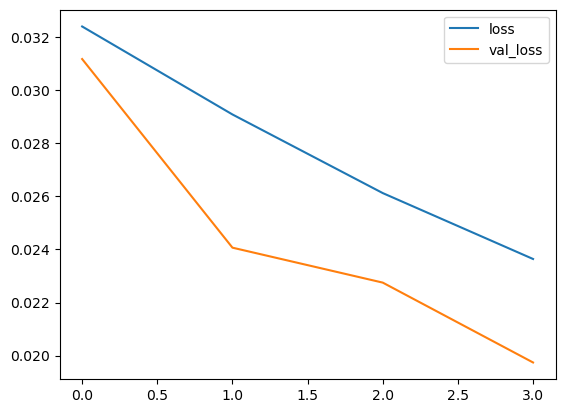

In [98]:
# loss and val_loss metrics 
history.history

# plot metrics
# in our case 1 pass over the data does not gerenate sufficient data points
# to do this we need to modify epochs to maybe 5 or 10
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Predictions

In [ ]:
# for batch predictions
batch = test.as_numpy_iterator().next()

# expected string as integer for model 
input_text = vectorizer('I love You!')

# predict
# returns array whose index correspond to labels(i.e df.columns[2:])
# model.predict(np.expand_dims(input_text,0))
model.predict(np.array([input_text]))


### Evaluate Model

In [ ]:
# import metric tools
from keras.metrics import Precision, Recall, CategoricalAccuracy

# allows us to update metrics as we iterate over batches
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    # unpack batch
    X_true, y_true = batch 
    # make prediction similar to above
    yhat = model.predict(X_true)
    # flatten predictions to one vector
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    # update metrics
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

# disp results
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


### Gradio App Demo

In [ ]:
# import demo tool
import gradio as gr 
# can also load model if running on different server
model.save('commentToxicity.h5')

# basic input flow
# tokenizing input
comment = vectorizer('I love you')
# prediction
res = model.predict(np.expand_dims(comment,0))


# func hooks into gradio model
def score_comment(comment):
    # tokenize input
    vectorized_comment = vectorizer([comment])
    # parse and feed model
    results = model.predict(vectorized_comment)
    
    # iterate through columns
    # thresold is >0.5 to return true 
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

# gradio inteface 
# flag element will create a .csv of flagged comments on user click
interface = gr.Interface(
    fn=score_comment, 
    inputs=gr.inputs.Textbox(lines=2, placeholder='input your comment ; shashi will rate your toxicity...'),
    outputs='text')

# enable/display public sharing                 
interface.launch(share=True)


***
# Conclusion
>
> This model is decent at classifying a given comment's toxicity, and it will only get better given more training time.
> 
> However, it would reason that a pre-trained transformer would be far superior.
>
> Note that to arrive at this conclusion the model was initially trained for roughly an hour.